<a href="https://colab.research.google.com/github/gourav10/autoencoder_embedding/blob/main/autoencoder_poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
!export PYTHONPATH=$PYTHONPATH:"/content/gdrive/MyDrive/CS7180"

In [ ]:
%cd /content/gdrive/MyDrive/CS7180

/content/gdrive/MyDrive/CS7180


In [ ]:
!pwd

/content/gdrive/MyDrive/CS7180


In [ ]:
!git clone https://github.com/gourav10/autoencoder_embedding.git

fatal: destination path 'autoencoder_embedding' already exists and is not an empty directory.


In [ ]:
# The MNIST datasets are hosted on yann.lecun.com that has moved under CloudFlare protection
# Run this script to enable the datasets download
# Reference: https://github.com/pytorch/vision/issues/1938
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [ ]:
%cd /content/gdrive/MyDrive/CS7180/autoencoder_embedding

/content/gdrive/MyDrive/CS7180/autoencoder_embedding


In [ ]:
DATA_DIR = '/content/gdrive/MyDrive/CS7180/autoencoder_embedding/data/'

In [ ]:
import os
os.makedirs(DATA_DIR,exist_ok=True)

In [ ]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
import plotly.io as pio
pio.renderers.default = 'colab'

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

In [ ]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root=DATA_DIR, train=True,
                                   download=True)#, transform=transform)
test_data = datasets.MNIST(root=DATA_DIR, train=False,
                                  download=True)#, transform=transform)

In [ ]:
# Create training and test dataloaders
num_workers = 0

# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

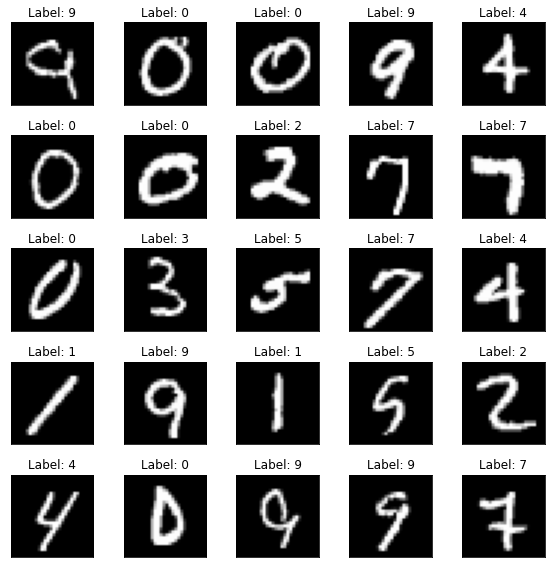

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_data)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_data.transform = train_transform
# Set the test transform
test_data.transform = test_transform

In [ ]:
m=len(train_data)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_data, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=True)

# 2. Define Autoencoders

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            #nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            #nn.BatchNorm2d(32),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [ ]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)

In [ ]:
### Some examples
# Take an input image (remember to add the batch dimension)
img, _ = test_data[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)
# Encode the image

img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)

# Decode the image
dec_img = decoder(img_enc)
#dec_img = model(img)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 4])
Decoded image shape: torch.Size([1, 1, 28, 28])


In [ ]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001
#lr = 0.0008 # Learning rate


params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)
#optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=6e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [ ]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [ ]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [ ]:
def plot_ae_outputs(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_data[i][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()

	 partial train loss (single batch): 0.253132
	 partial train loss (single batch): 0.246274
	 partial train loss (single batch): 0.240754
	 partial train loss (single batch): 0.236490
	 partial train loss (single batch): 0.231860
	 partial train loss (single batch): 0.228791
	 partial train loss (single batch): 0.225672
	 partial train loss (single batch): 0.222736
	 partial train loss (single batch): 0.220316
	 partial train loss (single batch): 0.217387
	 partial train loss (single batch): 0.215543
	 partial train loss (single batch): 0.213475
	 partial train loss (single batch): 0.211830
	 partial train loss (single batch): 0.209690
	 partial train loss (single batch): 0.207573
	 partial train loss (single batch): 0.205326
	 partial train loss (single batch): 0.203523
	 partial train loss (single batch): 0.201626
	 partial train loss (single batch): 0.199997
	 partial train loss (single batch): 0.197582
	 partial train loss (single batch): 0.196359
	 partial train loss (single batch

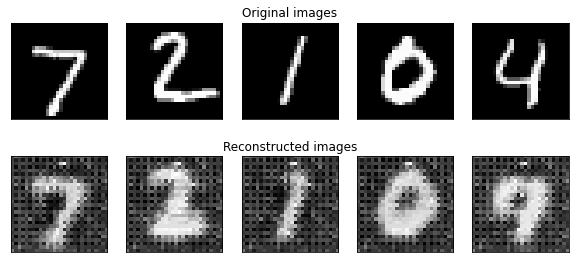

	 partial train loss (single batch): 0.067611
	 partial train loss (single batch): 0.067209
	 partial train loss (single batch): 0.066616
	 partial train loss (single batch): 0.065981
	 partial train loss (single batch): 0.066357
	 partial train loss (single batch): 0.065644
	 partial train loss (single batch): 0.066121
	 partial train loss (single batch): 0.065473
	 partial train loss (single batch): 0.064238
	 partial train loss (single batch): 0.066244
	 partial train loss (single batch): 0.064935
	 partial train loss (single batch): 0.064449
	 partial train loss (single batch): 0.063869
	 partial train loss (single batch): 0.063152
	 partial train loss (single batch): 0.062916
	 partial train loss (single batch): 0.064258
	 partial train loss (single batch): 0.062314
	 partial train loss (single batch): 0.063853
	 partial train loss (single batch): 0.062224
	 partial train loss (single batch): 0.063023
	 partial train loss (single batch): 0.062072
	 partial train loss (single batch

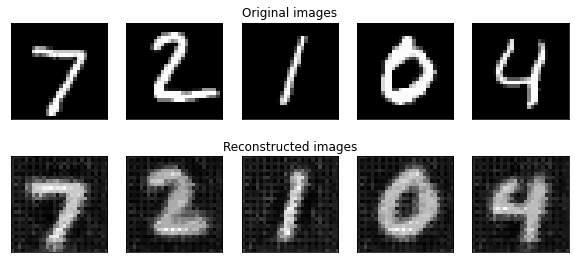

	 partial train loss (single batch): 0.048540
	 partial train loss (single batch): 0.048085
	 partial train loss (single batch): 0.047870
	 partial train loss (single batch): 0.047115
	 partial train loss (single batch): 0.048338
	 partial train loss (single batch): 0.047428
	 partial train loss (single batch): 0.047994
	 partial train loss (single batch): 0.047226
	 partial train loss (single batch): 0.046715
	 partial train loss (single batch): 0.048513
	 partial train loss (single batch): 0.047381
	 partial train loss (single batch): 0.046637
	 partial train loss (single batch): 0.046697
	 partial train loss (single batch): 0.045981
	 partial train loss (single batch): 0.045879
	 partial train loss (single batch): 0.047786
	 partial train loss (single batch): 0.045968
	 partial train loss (single batch): 0.047553
	 partial train loss (single batch): 0.045931
	 partial train loss (single batch): 0.046740
	 partial train loss (single batch): 0.046154
	 partial train loss (single batch

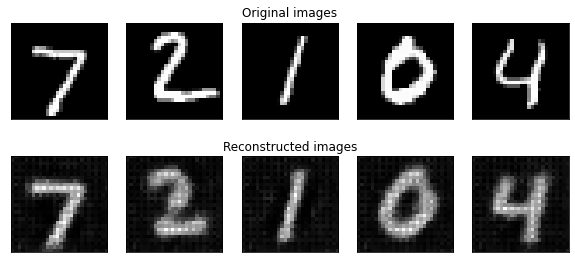

	 partial train loss (single batch): 0.040479
	 partial train loss (single batch): 0.039572
	 partial train loss (single batch): 0.039795
	 partial train loss (single batch): 0.038933
	 partial train loss (single batch): 0.040128
	 partial train loss (single batch): 0.039329
	 partial train loss (single batch): 0.039766
	 partial train loss (single batch): 0.038646
	 partial train loss (single batch): 0.038708
	 partial train loss (single batch): 0.040007
	 partial train loss (single batch): 0.039191
	 partial train loss (single batch): 0.038537
	 partial train loss (single batch): 0.038713
	 partial train loss (single batch): 0.037484
	 partial train loss (single batch): 0.038287
	 partial train loss (single batch): 0.039885
	 partial train loss (single batch): 0.038069
	 partial train loss (single batch): 0.039377
	 partial train loss (single batch): 0.037886
	 partial train loss (single batch): 0.038320
	 partial train loss (single batch): 0.037555
	 partial train loss (single batch

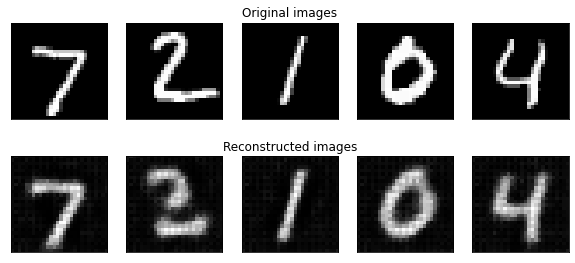

	 partial train loss (single batch): 0.035569
	 partial train loss (single batch): 0.034084
	 partial train loss (single batch): 0.034885
	 partial train loss (single batch): 0.033705
	 partial train loss (single batch): 0.034949
	 partial train loss (single batch): 0.034577
	 partial train loss (single batch): 0.034407
	 partial train loss (single batch): 0.033472
	 partial train loss (single batch): 0.033904
	 partial train loss (single batch): 0.034995
	 partial train loss (single batch): 0.034040
	 partial train loss (single batch): 0.033420
	 partial train loss (single batch): 0.033680
	 partial train loss (single batch): 0.032225
	 partial train loss (single batch): 0.033796
	 partial train loss (single batch): 0.035143
	 partial train loss (single batch): 0.033293
	 partial train loss (single batch): 0.034420
	 partial train loss (single batch): 0.033344
	 partial train loss (single batch): 0.033077
	 partial train loss (single batch): 0.032778
	 partial train loss (single batch

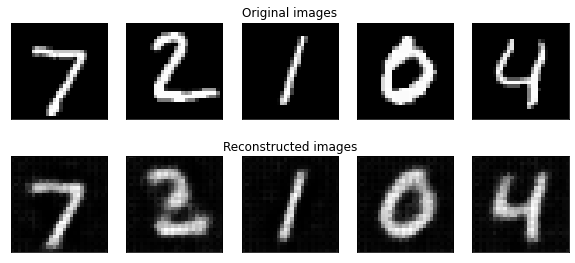

	 partial train loss (single batch): 0.033294
	 partial train loss (single batch): 0.032186
	 partial train loss (single batch): 0.032668
	 partial train loss (single batch): 0.031445
	 partial train loss (single batch): 0.032843
	 partial train loss (single batch): 0.032261
	 partial train loss (single batch): 0.031946
	 partial train loss (single batch): 0.031326
	 partial train loss (single batch): 0.031710
	 partial train loss (single batch): 0.032857
	 partial train loss (single batch): 0.031998
	 partial train loss (single batch): 0.031631
	 partial train loss (single batch): 0.031562
	 partial train loss (single batch): 0.030007
	 partial train loss (single batch): 0.031989
	 partial train loss (single batch): 0.033002
	 partial train loss (single batch): 0.031307
	 partial train loss (single batch): 0.032223
	 partial train loss (single batch): 0.031544
	 partial train loss (single batch): 0.030806
	 partial train loss (single batch): 0.030653
	 partial train loss (single batch

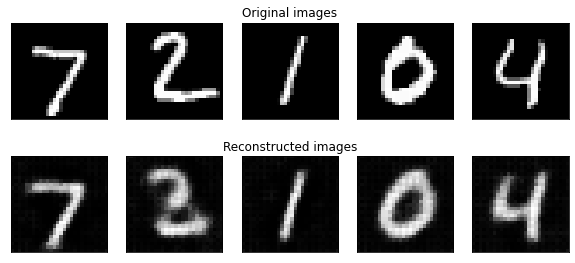

	 partial train loss (single batch): 0.032031
	 partial train loss (single batch): 0.031060
	 partial train loss (single batch): 0.031472
	 partial train loss (single batch): 0.030311
	 partial train loss (single batch): 0.031659
	 partial train loss (single batch): 0.031186
	 partial train loss (single batch): 0.030747
	 partial train loss (single batch): 0.030177
	 partial train loss (single batch): 0.030666
	 partial train loss (single batch): 0.031750
	 partial train loss (single batch): 0.030610
	 partial train loss (single batch): 0.030640
	 partial train loss (single batch): 0.030612
	 partial train loss (single batch): 0.028875
	 partial train loss (single batch): 0.030784
	 partial train loss (single batch): 0.031843
	 partial train loss (single batch): 0.030378
	 partial train loss (single batch): 0.031190
	 partial train loss (single batch): 0.030443
	 partial train loss (single batch): 0.029808
	 partial train loss (single batch): 0.029507
	 partial train loss (single batch

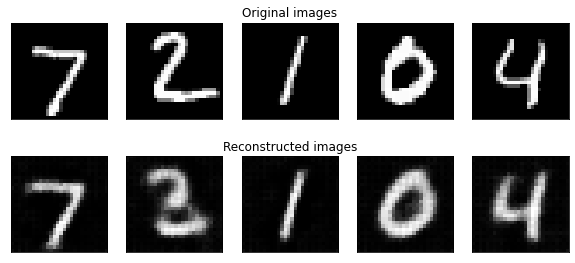

	 partial train loss (single batch): 0.031241
	 partial train loss (single batch): 0.030200
	 partial train loss (single batch): 0.030693
	 partial train loss (single batch): 0.029279
	 partial train loss (single batch): 0.030742
	 partial train loss (single batch): 0.030468
	 partial train loss (single batch): 0.029869
	 partial train loss (single batch): 0.029395
	 partial train loss (single batch): 0.029844
	 partial train loss (single batch): 0.030865
	 partial train loss (single batch): 0.029885
	 partial train loss (single batch): 0.029776
	 partial train loss (single batch): 0.029897
	 partial train loss (single batch): 0.028243
	 partial train loss (single batch): 0.029964
	 partial train loss (single batch): 0.031068
	 partial train loss (single batch): 0.029783
	 partial train loss (single batch): 0.030560
	 partial train loss (single batch): 0.029678
	 partial train loss (single batch): 0.029076
	 partial train loss (single batch): 0.028824
	 partial train loss (single batch

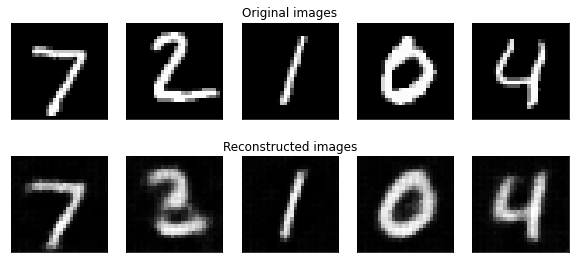

	 partial train loss (single batch): 0.030540
	 partial train loss (single batch): 0.029465
	 partial train loss (single batch): 0.029997
	 partial train loss (single batch): 0.028656
	 partial train loss (single batch): 0.029968
	 partial train loss (single batch): 0.029823
	 partial train loss (single batch): 0.029307
	 partial train loss (single batch): 0.028796
	 partial train loss (single batch): 0.029115
	 partial train loss (single batch): 0.030194
	 partial train loss (single batch): 0.029209
	 partial train loss (single batch): 0.029234
	 partial train loss (single batch): 0.029328
	 partial train loss (single batch): 0.027631
	 partial train loss (single batch): 0.029313
	 partial train loss (single batch): 0.030367
	 partial train loss (single batch): 0.029015
	 partial train loss (single batch): 0.029875
	 partial train loss (single batch): 0.028912
	 partial train loss (single batch): 0.028456
	 partial train loss (single batch): 0.028260
	 partial train loss (single batch

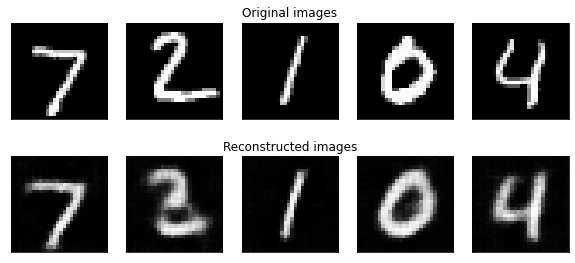

	 partial train loss (single batch): 0.030042
	 partial train loss (single batch): 0.028977
	 partial train loss (single batch): 0.029544
	 partial train loss (single batch): 0.028285
	 partial train loss (single batch): 0.029410
	 partial train loss (single batch): 0.029434
	 partial train loss (single batch): 0.028917
	 partial train loss (single batch): 0.028244
	 partial train loss (single batch): 0.028635
	 partial train loss (single batch): 0.029643
	 partial train loss (single batch): 0.028752
	 partial train loss (single batch): 0.028894
	 partial train loss (single batch): 0.028923
	 partial train loss (single batch): 0.027279
	 partial train loss (single batch): 0.028828
	 partial train loss (single batch): 0.029919
	 partial train loss (single batch): 0.028547
	 partial train loss (single batch): 0.029472
	 partial train loss (single batch): 0.028387
	 partial train loss (single batch): 0.028025
	 partial train loss (single batch): 0.027714
	 partial train loss (single batch

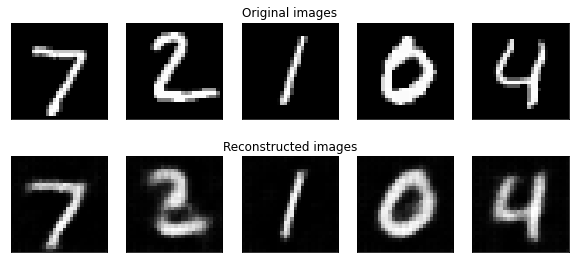

	 partial train loss (single batch): 0.029654
	 partial train loss (single batch): 0.028525
	 partial train loss (single batch): 0.029013
	 partial train loss (single batch): 0.027864
	 partial train loss (single batch): 0.028972
	 partial train loss (single batch): 0.029096
	 partial train loss (single batch): 0.028627
	 partial train loss (single batch): 0.027859
	 partial train loss (single batch): 0.028105
	 partial train loss (single batch): 0.029297
	 partial train loss (single batch): 0.028380
	 partial train loss (single batch): 0.028571
	 partial train loss (single batch): 0.028631
	 partial train loss (single batch): 0.027036
	 partial train loss (single batch): 0.028447
	 partial train loss (single batch): 0.029453
	 partial train loss (single batch): 0.028156
	 partial train loss (single batch): 0.029106
	 partial train loss (single batch): 0.027960
	 partial train loss (single batch): 0.027644
	 partial train loss (single batch): 0.027236
	 partial train loss (single batch

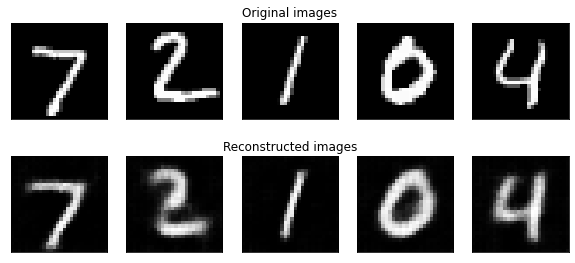

	 partial train loss (single batch): 0.029295
	 partial train loss (single batch): 0.028089
	 partial train loss (single batch): 0.028684
	 partial train loss (single batch): 0.027553
	 partial train loss (single batch): 0.028657
	 partial train loss (single batch): 0.028695
	 partial train loss (single batch): 0.028481
	 partial train loss (single batch): 0.027578
	 partial train loss (single batch): 0.027568
	 partial train loss (single batch): 0.028841
	 partial train loss (single batch): 0.028049
	 partial train loss (single batch): 0.028338
	 partial train loss (single batch): 0.028180
	 partial train loss (single batch): 0.026715
	 partial train loss (single batch): 0.028072
	 partial train loss (single batch): 0.028966
	 partial train loss (single batch): 0.027906
	 partial train loss (single batch): 0.028766
	 partial train loss (single batch): 0.027394
	 partial train loss (single batch): 0.027337
	 partial train loss (single batch): 0.026946
	 partial train loss (single batch

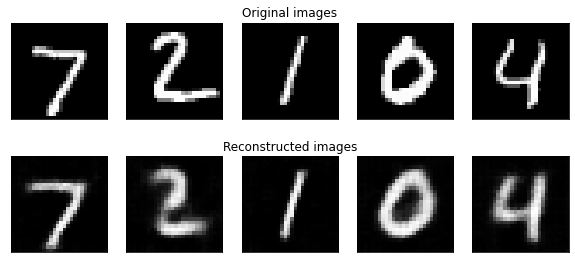

	 partial train loss (single batch): 0.028920
	 partial train loss (single batch): 0.027914
	 partial train loss (single batch): 0.028377
	 partial train loss (single batch): 0.027363
	 partial train loss (single batch): 0.028418
	 partial train loss (single batch): 0.028335
	 partial train loss (single batch): 0.028189
	 partial train loss (single batch): 0.027360
	 partial train loss (single batch): 0.027182
	 partial train loss (single batch): 0.028529
	 partial train loss (single batch): 0.027806
	 partial train loss (single batch): 0.028022
	 partial train loss (single batch): 0.027807
	 partial train loss (single batch): 0.026443
	 partial train loss (single batch): 0.027820
	 partial train loss (single batch): 0.028500
	 partial train loss (single batch): 0.027571
	 partial train loss (single batch): 0.028434
	 partial train loss (single batch): 0.027110
	 partial train loss (single batch): 0.027011
	 partial train loss (single batch): 0.026623
	 partial train loss (single batch

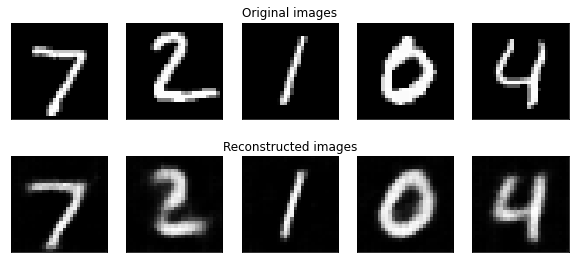

	 partial train loss (single batch): 0.028452
	 partial train loss (single batch): 0.027594
	 partial train loss (single batch): 0.028093
	 partial train loss (single batch): 0.027110
	 partial train loss (single batch): 0.028121
	 partial train loss (single batch): 0.028004
	 partial train loss (single batch): 0.027875
	 partial train loss (single batch): 0.027134
	 partial train loss (single batch): 0.026866
	 partial train loss (single batch): 0.028238
	 partial train loss (single batch): 0.027509
	 partial train loss (single batch): 0.027801
	 partial train loss (single batch): 0.027444
	 partial train loss (single batch): 0.026124
	 partial train loss (single batch): 0.027577
	 partial train loss (single batch): 0.028199
	 partial train loss (single batch): 0.027261
	 partial train loss (single batch): 0.028168
	 partial train loss (single batch): 0.026800
	 partial train loss (single batch): 0.026755
	 partial train loss (single batch): 0.026322
	 partial train loss (single batch

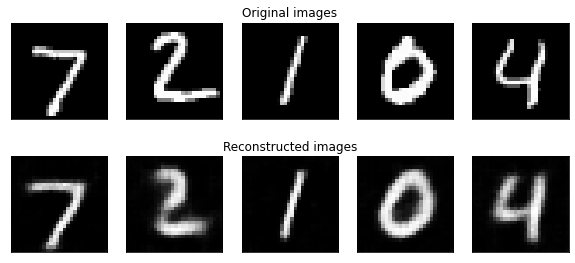

	 partial train loss (single batch): 0.028170
	 partial train loss (single batch): 0.027390
	 partial train loss (single batch): 0.027897
	 partial train loss (single batch): 0.026742
	 partial train loss (single batch): 0.027830
	 partial train loss (single batch): 0.027744
	 partial train loss (single batch): 0.027774
	 partial train loss (single batch): 0.026980
	 partial train loss (single batch): 0.026549
	 partial train loss (single batch): 0.028020
	 partial train loss (single batch): 0.027300
	 partial train loss (single batch): 0.027565
	 partial train loss (single batch): 0.027126
	 partial train loss (single batch): 0.025887
	 partial train loss (single batch): 0.027431
	 partial train loss (single batch): 0.027851
	 partial train loss (single batch): 0.027029
	 partial train loss (single batch): 0.028060
	 partial train loss (single batch): 0.026613
	 partial train loss (single batch): 0.026649
	 partial train loss (single batch): 0.026023
	 partial train loss (single batch

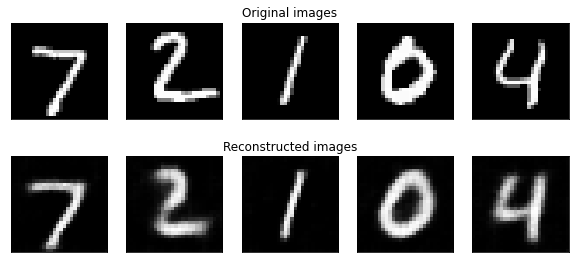

	 partial train loss (single batch): 0.027927
	 partial train loss (single batch): 0.027192
	 partial train loss (single batch): 0.027580
	 partial train loss (single batch): 0.026437
	 partial train loss (single batch): 0.027551
	 partial train loss (single batch): 0.027540
	 partial train loss (single batch): 0.027537
	 partial train loss (single batch): 0.026706
	 partial train loss (single batch): 0.026339
	 partial train loss (single batch): 0.027797
	 partial train loss (single batch): 0.027101
	 partial train loss (single batch): 0.027336
	 partial train loss (single batch): 0.026775
	 partial train loss (single batch): 0.025548
	 partial train loss (single batch): 0.027202
	 partial train loss (single batch): 0.027542
	 partial train loss (single batch): 0.026818
	 partial train loss (single batch): 0.027765
	 partial train loss (single batch): 0.026429
	 partial train loss (single batch): 0.026448
	 partial train loss (single batch): 0.025802
	 partial train loss (single batch

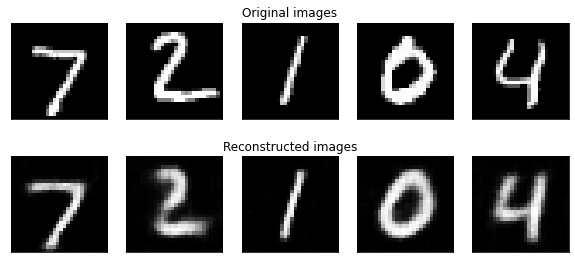

	 partial train loss (single batch): 0.027735
	 partial train loss (single batch): 0.027049
	 partial train loss (single batch): 0.027387
	 partial train loss (single batch): 0.026249
	 partial train loss (single batch): 0.027285
	 partial train loss (single batch): 0.027239
	 partial train loss (single batch): 0.027456
	 partial train loss (single batch): 0.026598
	 partial train loss (single batch): 0.026231
	 partial train loss (single batch): 0.027541
	 partial train loss (single batch): 0.026930
	 partial train loss (single batch): 0.027181
	 partial train loss (single batch): 0.026596
	 partial train loss (single batch): 0.025352
	 partial train loss (single batch): 0.026981
	 partial train loss (single batch): 0.027261
	 partial train loss (single batch): 0.026658
	 partial train loss (single batch): 0.027501
	 partial train loss (single batch): 0.026294
	 partial train loss (single batch): 0.026376
	 partial train loss (single batch): 0.025669
	 partial train loss (single batch

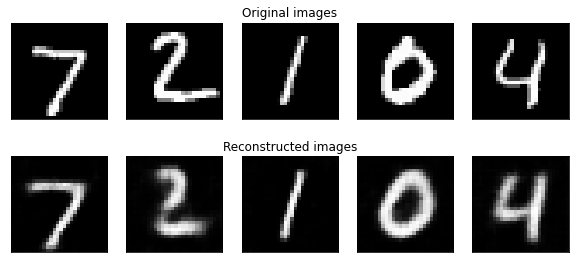

	 partial train loss (single batch): 0.027552
	 partial train loss (single batch): 0.026932
	 partial train loss (single batch): 0.027275
	 partial train loss (single batch): 0.026023
	 partial train loss (single batch): 0.027116
	 partial train loss (single batch): 0.027042
	 partial train loss (single batch): 0.027400
	 partial train loss (single batch): 0.026356
	 partial train loss (single batch): 0.026009
	 partial train loss (single batch): 0.027437
	 partial train loss (single batch): 0.026765
	 partial train loss (single batch): 0.026941
	 partial train loss (single batch): 0.026354
	 partial train loss (single batch): 0.025188
	 partial train loss (single batch): 0.026869
	 partial train loss (single batch): 0.027074
	 partial train loss (single batch): 0.026570
	 partial train loss (single batch): 0.027274
	 partial train loss (single batch): 0.026078
	 partial train loss (single batch): 0.026197
	 partial train loss (single batch): 0.025391
	 partial train loss (single batch

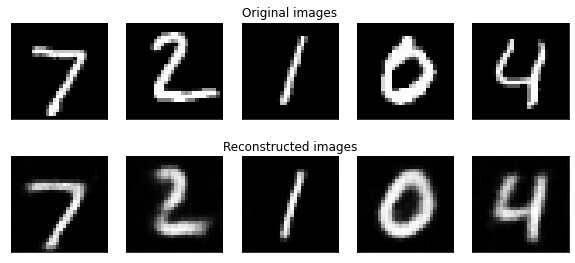

	 partial train loss (single batch): 0.027399
	 partial train loss (single batch): 0.026776
	 partial train loss (single batch): 0.027165
	 partial train loss (single batch): 0.025804
	 partial train loss (single batch): 0.026959
	 partial train loss (single batch): 0.026886
	 partial train loss (single batch): 0.027288
	 partial train loss (single batch): 0.026217
	 partial train loss (single batch): 0.025871
	 partial train loss (single batch): 0.027243
	 partial train loss (single batch): 0.026580
	 partial train loss (single batch): 0.026784
	 partial train loss (single batch): 0.026192
	 partial train loss (single batch): 0.025031
	 partial train loss (single batch): 0.026724
	 partial train loss (single batch): 0.026870
	 partial train loss (single batch): 0.026369
	 partial train loss (single batch): 0.027017
	 partial train loss (single batch): 0.025894
	 partial train loss (single batch): 0.026059
	 partial train loss (single batch): 0.025188
	 partial train loss (single batch

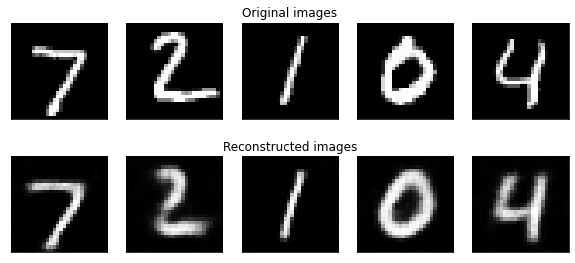

	 partial train loss (single batch): 0.027153
	 partial train loss (single batch): 0.026609
	 partial train loss (single batch): 0.027001
	 partial train loss (single batch): 0.025693
	 partial train loss (single batch): 0.026805
	 partial train loss (single batch): 0.026734
	 partial train loss (single batch): 0.027236
	 partial train loss (single batch): 0.026100
	 partial train loss (single batch): 0.025790
	 partial train loss (single batch): 0.027091
	 partial train loss (single batch): 0.026422
	 partial train loss (single batch): 0.026551
	 partial train loss (single batch): 0.026022
	 partial train loss (single batch): 0.024836
	 partial train loss (single batch): 0.026539
	 partial train loss (single batch): 0.026717
	 partial train loss (single batch): 0.026197
	 partial train loss (single batch): 0.026821
	 partial train loss (single batch): 0.025736
	 partial train loss (single batch): 0.025912
	 partial train loss (single batch): 0.025018
	 partial train loss (single batch

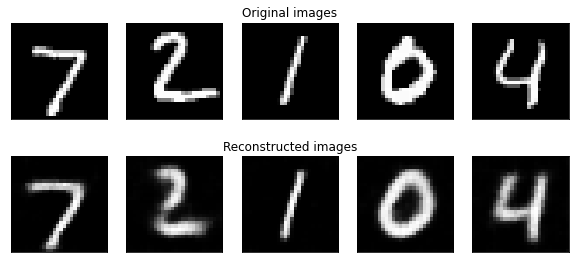

	 partial train loss (single batch): 0.026974
	 partial train loss (single batch): 0.026527
	 partial train loss (single batch): 0.026873
	 partial train loss (single batch): 0.025599
	 partial train loss (single batch): 0.026650
	 partial train loss (single batch): 0.026602
	 partial train loss (single batch): 0.027103
	 partial train loss (single batch): 0.025881
	 partial train loss (single batch): 0.025635
	 partial train loss (single batch): 0.026968
	 partial train loss (single batch): 0.026257
	 partial train loss (single batch): 0.026439
	 partial train loss (single batch): 0.025865
	 partial train loss (single batch): 0.024726
	 partial train loss (single batch): 0.026472
	 partial train loss (single batch): 0.026548
	 partial train loss (single batch): 0.026076
	 partial train loss (single batch): 0.026734
	 partial train loss (single batch): 0.025641
	 partial train loss (single batch): 0.025760
	 partial train loss (single batch): 0.024843
	 partial train loss (single batch

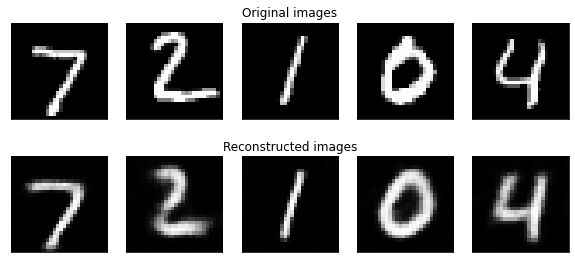

	 partial train loss (single batch): 0.026903
	 partial train loss (single batch): 0.026313
	 partial train loss (single batch): 0.026896
	 partial train loss (single batch): 0.025489
	 partial train loss (single batch): 0.026542
	 partial train loss (single batch): 0.026535
	 partial train loss (single batch): 0.027038
	 partial train loss (single batch): 0.025798
	 partial train loss (single batch): 0.025534
	 partial train loss (single batch): 0.026851
	 partial train loss (single batch): 0.026117
	 partial train loss (single batch): 0.026337
	 partial train loss (single batch): 0.025720
	 partial train loss (single batch): 0.024654
	 partial train loss (single batch): 0.026416
	 partial train loss (single batch): 0.026378
	 partial train loss (single batch): 0.025941
	 partial train loss (single batch): 0.026628
	 partial train loss (single batch): 0.025483
	 partial train loss (single batch): 0.025610
	 partial train loss (single batch): 0.024648
	 partial train loss (single batch

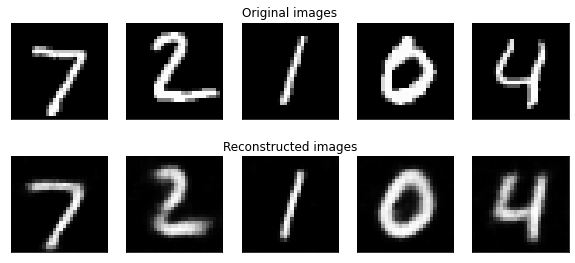

	 partial train loss (single batch): 0.026765
	 partial train loss (single batch): 0.026168
	 partial train loss (single batch): 0.026796
	 partial train loss (single batch): 0.025407
	 partial train loss (single batch): 0.026467
	 partial train loss (single batch): 0.026303
	 partial train loss (single batch): 0.026937
	 partial train loss (single batch): 0.025729
	 partial train loss (single batch): 0.025398
	 partial train loss (single batch): 0.026721
	 partial train loss (single batch): 0.026006
	 partial train loss (single batch): 0.026276
	 partial train loss (single batch): 0.025553
	 partial train loss (single batch): 0.024488
	 partial train loss (single batch): 0.026306
	 partial train loss (single batch): 0.026169
	 partial train loss (single batch): 0.025760
	 partial train loss (single batch): 0.026605
	 partial train loss (single batch): 0.025418
	 partial train loss (single batch): 0.025576
	 partial train loss (single batch): 0.024572
	 partial train loss (single batch

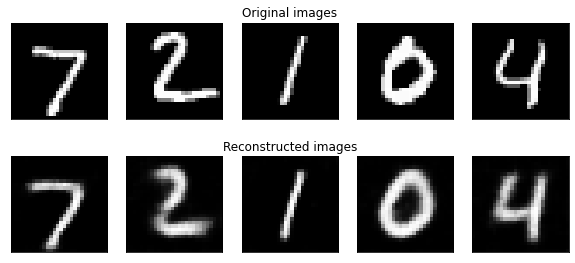

	 partial train loss (single batch): 0.026627
	 partial train loss (single batch): 0.026017
	 partial train loss (single batch): 0.026656
	 partial train loss (single batch): 0.025231
	 partial train loss (single batch): 0.026379
	 partial train loss (single batch): 0.026161
	 partial train loss (single batch): 0.026658
	 partial train loss (single batch): 0.025564
	 partial train loss (single batch): 0.025342
	 partial train loss (single batch): 0.026601
	 partial train loss (single batch): 0.025938
	 partial train loss (single batch): 0.026171
	 partial train loss (single batch): 0.025494
	 partial train loss (single batch): 0.024332
	 partial train loss (single batch): 0.026254
	 partial train loss (single batch): 0.026098
	 partial train loss (single batch): 0.025630
	 partial train loss (single batch): 0.026548
	 partial train loss (single batch): 0.025394
	 partial train loss (single batch): 0.025582
	 partial train loss (single batch): 0.024478
	 partial train loss (single batch

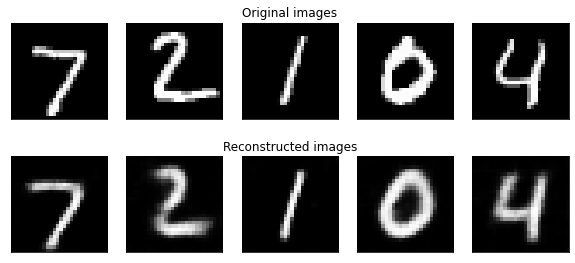

	 partial train loss (single batch): 0.026558
	 partial train loss (single batch): 0.025956
	 partial train loss (single batch): 0.026586
	 partial train loss (single batch): 0.025169
	 partial train loss (single batch): 0.026310
	 partial train loss (single batch): 0.026123
	 partial train loss (single batch): 0.026664
	 partial train loss (single batch): 0.025534
	 partial train loss (single batch): 0.025245
	 partial train loss (single batch): 0.026519
	 partial train loss (single batch): 0.025858
	 partial train loss (single batch): 0.026112
	 partial train loss (single batch): 0.025414
	 partial train loss (single batch): 0.024303
	 partial train loss (single batch): 0.026196
	 partial train loss (single batch): 0.026003
	 partial train loss (single batch): 0.025525
	 partial train loss (single batch): 0.026501
	 partial train loss (single batch): 0.025382
	 partial train loss (single batch): 0.025402
	 partial train loss (single batch): 0.024406
	 partial train loss (single batch

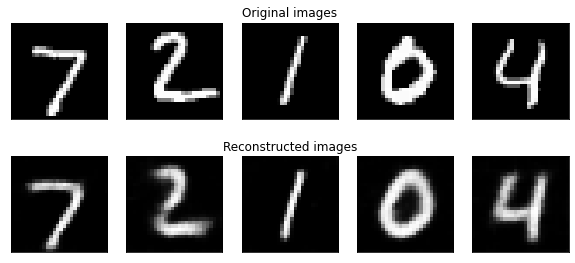

	 partial train loss (single batch): 0.026390
	 partial train loss (single batch): 0.025835
	 partial train loss (single batch): 0.026569
	 partial train loss (single batch): 0.025164
	 partial train loss (single batch): 0.026229
	 partial train loss (single batch): 0.025941
	 partial train loss (single batch): 0.026640
	 partial train loss (single batch): 0.025513
	 partial train loss (single batch): 0.025221
	 partial train loss (single batch): 0.026409
	 partial train loss (single batch): 0.025770
	 partial train loss (single batch): 0.026041
	 partial train loss (single batch): 0.025418
	 partial train loss (single batch): 0.024299
	 partial train loss (single batch): 0.026057
	 partial train loss (single batch): 0.025899
	 partial train loss (single batch): 0.025425
	 partial train loss (single batch): 0.026417
	 partial train loss (single batch): 0.025329
	 partial train loss (single batch): 0.025353
	 partial train loss (single batch): 0.024281
	 partial train loss (single batch

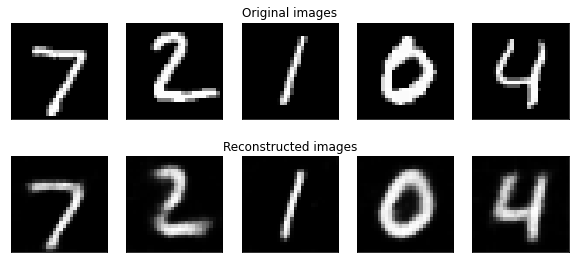

	 partial train loss (single batch): 0.026294
	 partial train loss (single batch): 0.025738
	 partial train loss (single batch): 0.026425
	 partial train loss (single batch): 0.025018
	 partial train loss (single batch): 0.026158
	 partial train loss (single batch): 0.025935
	 partial train loss (single batch): 0.026583
	 partial train loss (single batch): 0.025385
	 partial train loss (single batch): 0.025157
	 partial train loss (single batch): 0.026381
	 partial train loss (single batch): 0.025701
	 partial train loss (single batch): 0.026055
	 partial train loss (single batch): 0.025347
	 partial train loss (single batch): 0.024251
	 partial train loss (single batch): 0.026051
	 partial train loss (single batch): 0.025963
	 partial train loss (single batch): 0.025361
	 partial train loss (single batch): 0.026371
	 partial train loss (single batch): 0.025248
	 partial train loss (single batch): 0.025239
	 partial train loss (single batch): 0.024222
	 partial train loss (single batch

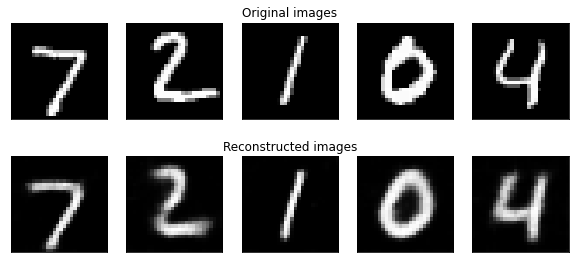

	 partial train loss (single batch): 0.026234
	 partial train loss (single batch): 0.025616
	 partial train loss (single batch): 0.026382
	 partial train loss (single batch): 0.025011
	 partial train loss (single batch): 0.026128
	 partial train loss (single batch): 0.025879
	 partial train loss (single batch): 0.026567
	 partial train loss (single batch): 0.025314
	 partial train loss (single batch): 0.025109
	 partial train loss (single batch): 0.026383
	 partial train loss (single batch): 0.025677
	 partial train loss (single batch): 0.026035
	 partial train loss (single batch): 0.025249
	 partial train loss (single batch): 0.024166
	 partial train loss (single batch): 0.025990
	 partial train loss (single batch): 0.025844
	 partial train loss (single batch): 0.025269
	 partial train loss (single batch): 0.026329
	 partial train loss (single batch): 0.025176
	 partial train loss (single batch): 0.025193
	 partial train loss (single batch): 0.024160
	 partial train loss (single batch

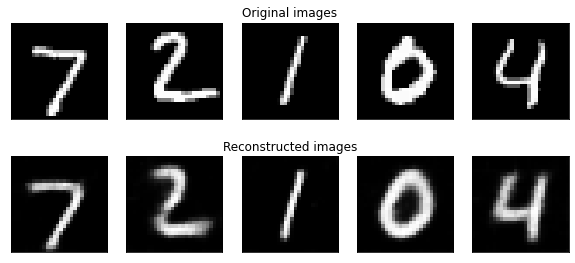

	 partial train loss (single batch): 0.026115
	 partial train loss (single batch): 0.025500
	 partial train loss (single batch): 0.026259
	 partial train loss (single batch): 0.024965
	 partial train loss (single batch): 0.026084
	 partial train loss (single batch): 0.025813
	 partial train loss (single batch): 0.026483
	 partial train loss (single batch): 0.025206
	 partial train loss (single batch): 0.024998
	 partial train loss (single batch): 0.026244
	 partial train loss (single batch): 0.025584
	 partial train loss (single batch): 0.025958
	 partial train loss (single batch): 0.025197
	 partial train loss (single batch): 0.024075
	 partial train loss (single batch): 0.025938
	 partial train loss (single batch): 0.025722
	 partial train loss (single batch): 0.025208
	 partial train loss (single batch): 0.026187
	 partial train loss (single batch): 0.025085
	 partial train loss (single batch): 0.025128
	 partial train loss (single batch): 0.024080
	 partial train loss (single batch

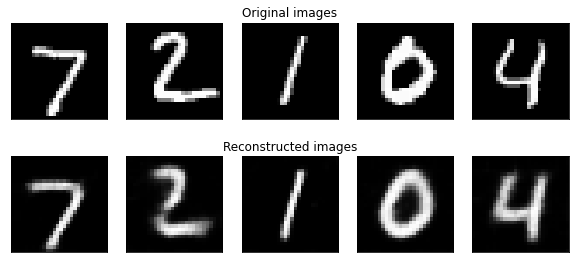

	 partial train loss (single batch): 0.026082
	 partial train loss (single batch): 0.025450
	 partial train loss (single batch): 0.026237
	 partial train loss (single batch): 0.024925
	 partial train loss (single batch): 0.026057
	 partial train loss (single batch): 0.025762
	 partial train loss (single batch): 0.026417
	 partial train loss (single batch): 0.025213
	 partial train loss (single batch): 0.024913
	 partial train loss (single batch): 0.026192
	 partial train loss (single batch): 0.025551
	 partial train loss (single batch): 0.025967
	 partial train loss (single batch): 0.025251
	 partial train loss (single batch): 0.023995
	 partial train loss (single batch): 0.025979
	 partial train loss (single batch): 0.025674
	 partial train loss (single batch): 0.025190
	 partial train loss (single batch): 0.026082
	 partial train loss (single batch): 0.025049
	 partial train loss (single batch): 0.025109
	 partial train loss (single batch): 0.024143
	 partial train loss (single batch

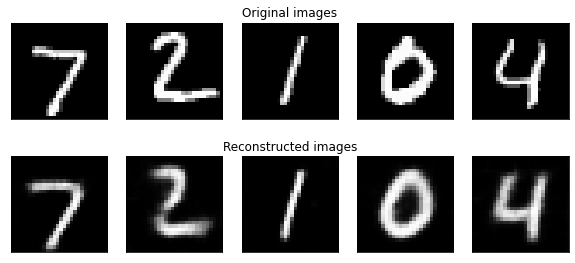

In [ ]:
num_epochs = 30
history={'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):

   train_loss = train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,valid_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   history['train_loss'].append(train_loss)
   history['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=5)

In [ ]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.02632240578532219

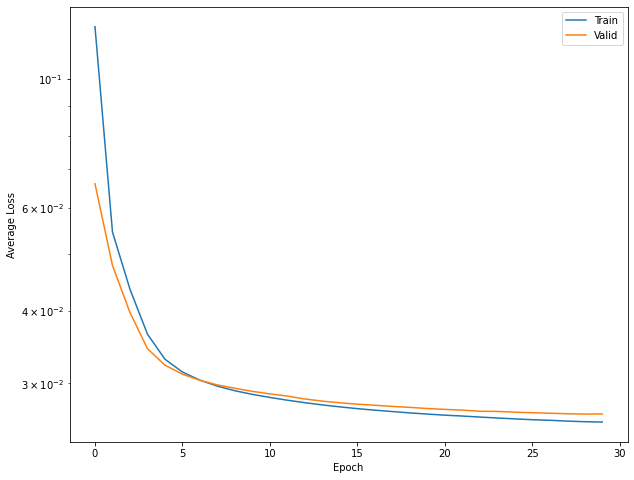

In [ ]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(history['train_loss'], label='Train')
plt.semilogy(history['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

#5. Generate new samples from the latent code

In [ ]:
def plot_reconstructed(decoder, r0=(-5, 10), r1=(-10, 5), n=10):
    plt.figure(figsize=(20,8.5))
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap='gist_gray')

In [ ]:
plot_reconstructed(decoder, r0=(-1, 1), r1=(-1, 1))

RuntimeError: ignored

<Figure size 1440x612 with 0 Axes>

In [ ]:
encoded_samples = []
for sample in tqdm(test_data):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:11<00:00, 890.72it/s]


In [ ]:
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,label
0,-3.841144,1.054060,-0.305749,-0.645092,7
1,0.576603,0.975832,0.821027,-0.077867,2
2,-0.145258,1.326825,-0.760427,-0.355420,1
3,-0.241316,-0.775457,0.670025,0.064489,0
4,-0.556000,-0.688575,-0.484745,-0.983373,4
...,...,...,...,...,...
9995,0.099015,0.692382,0.999878,0.796114,2
9996,0.646991,0.240150,0.733369,-0.267776,3
9997,-0.756807,-0.197370,-1.046464,-0.464362,4
9998,0.959851,-1.069556,-0.863886,0.252494,5


In [ ]:
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

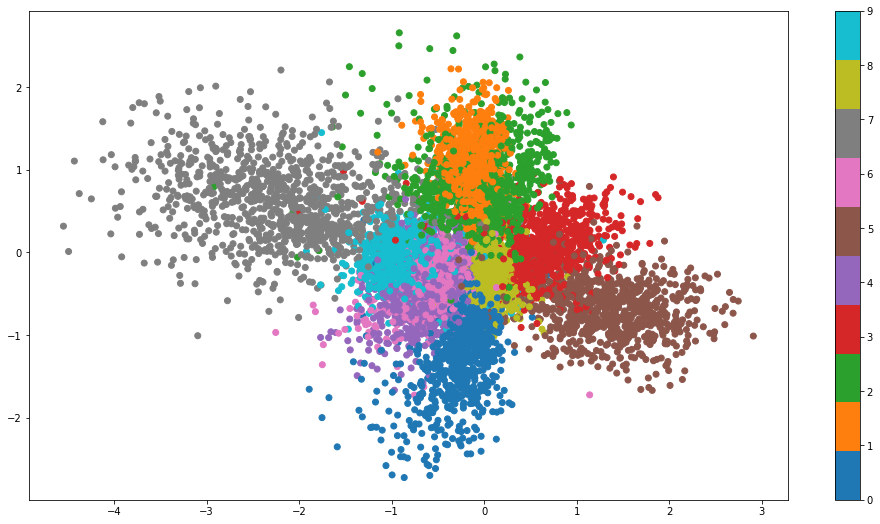

In [ ]:
plt.figure(figsize=(17, 9))
plt.scatter(encoded_samples['Enc. Variable 0'], encoded_samples['Enc. Variable 1'], c=encoded_samples.label, cmap='tab10')
plt.colorbar()
plt.show()

In [ ]:
pca = PCA(n_components=2)
components = pca.fit_transform(encoded_samples.drop(['label'],axis=1))
total_var = pca.explained_variance_ratio_.sum() * 100
print(total_var)

69.94767189025879


In [ ]:
fig = px.scatter(components, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'PC 1', '1': 'PC 2'})
fig.show()

In [ ]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()